### Scatter plot for evaluating FLC estimation performance

* data in  `FLCI_scatter_plot_data` generated in `FLCI.ipynb` and `satellite_image.ipynb`

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = 'FLCI_scatter_plot_data/'
flc_est_file = 'btd_georgesbank_20240620.nc'
sat_btd_file = 'satellite_2024_06_20_06Z.nc'

flc_est = xr.open_dataset(data_dir+flc_est_file)
sat_btd = xr.open_dataset(data_dir+sat_btd_file)

In [4]:
sat_btd

<xarray.Dataset> Size: 7MB
Dimensions:                        (y: 491, x: 720)
Coordinates:
    y_image                        float32 4B ...
    x_image                        float32 4B ...
  * y                              (y) float32 2kB 0.1204 0.1203 ... 0.09293
  * x                              (x) float32 3kB 0.004116 0.004172 ... 0.04438
    lat                            (y, x) float64 3MB ...
    lon                            (y, x) float64 3MB ...
Data variables:
    __xarray_dataarray_variable__  (y, x) float32 1MB ...

*Current issue: This creates a "diagonal stripe" of lat/lon pairs, where I want the full colocated rectangle.*

In [13]:

lat2d = sat_btd['lat'].values  # shape (y, x)
lon2d = sat_btd['lon'].values  # shape (y, x)

# Flatten the 2D grid to 1D for searching
lat_flat = lat2d.ravel()
lon_flat = lon2d.ravel()

# Stack the indices for later use
yx_pairs = np.indices(lat2d.shape).reshape(2, -1).T  # shape (N, 2)

# Example: lat/lon pairs from ds1
lat_vals = flc_est['latitude'].values
lon_vals = flc_est['longitude'].values-360

results = []

for lat in lat_vals.ravel():
    for lon in lon_vals.ravel(): 
        # Compute distance to every point in ds2
        dists = np.sqrt((lat_flat - lat)**2 + (lon_flat - lon)**2)
        min_idx = np.argmin(dists)
        y_idx, x_idx = yx_pairs[min_idx]

        # Extract value at the nearest point
        value = sat_btd['__xarray_dataarray_variable__'].isel(y=y_idx, x=x_idx).values.item()

        results.append({'lat': lat, 'lon': lon, 'nearest_value': value})

# Convert to DataFrame for easy viewing
df_results = pd.DataFrame(results)


In [14]:
df_results

,lat,lon,nearest_value
0,46.0,-73.00,-9.551422
1,46.0,-72.75,-9.764282
2,46.0,-72.50,-7.564178
3,46.0,-72.25,-3.506042
4,46.0,-72.00,-2.840302
...,...,...,...
3440,33.0,-58.00,-0.468048
3441,33.0,-57.75,-0.254913
3442,33.0,-57.50,-0.431274
3443,33.0,-57.25,-0.324280


In [15]:
print(f'Shape of filtered sat IR BTD: {np.shape(df_results.nearest_value)}, shape of BTD estimation: {np.shape(flc_est.BTD.values)}')

Shape of filtered sat IR BTD: (3445,), shape of BTD estimation: (53, 65)


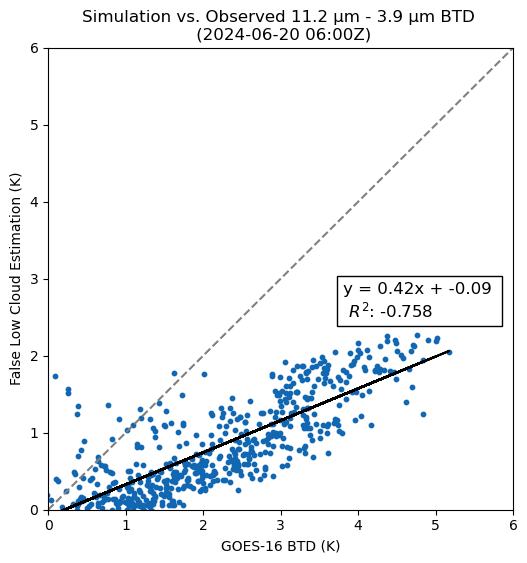

In [49]:
plt.figure(figsize=(6, 6))
plt.xlim(0, 6)
plt.ylim(0, 6)

x = df_results.nearest_value
y = flc_est.BTD.values.ravel()

#--- Removing nan values (land surfaces in BTD)
mask = ~np.isnan(y)
x = x[mask]
y = y[mask]

plt.scatter(x, y, color='#1167b1', marker='o', s=10)

#--- Ideal x=y line
plt.plot([0, 6], [0, 6], color='grey', linestyle='--')

#--- Best fit line
mask = (x >= 0) & (x <= 6) & (y >= 0) & (y <= 6)
x_filtered = x[mask]
y_filtered = y[mask]
slope, intercept = np.polyfit(x_filtered, y_filtered, 1)
y_fit = slope * x + intercept
#------ R² calculation
ss_res = np.sum((y - y_fit) ** 2)              # Residual sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)         # Total sum of squares
r_squared = 1 - (ss_res / ss_tot)              # R² formula
plt.plot(x, y_fit, color='black')

# Display R²
plt.text(3.8, 2.5, 
         f'y = {slope:.2f}x + {intercept:.2f} \n $R^2$: {r_squared:.3f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='black'))

plt.title("Simulation vs. Observed 11.2 μm - 3.9 μm BTD \n (2024-06-20 06:00Z)")
plt.xlabel("GOES-16 BTD (K)")
plt.ylabel("False Low Cloud Estimation (K)")

plt.show()